# Asteroid Centroiding Exercise

This exercise follows the Key Point Detection Tutorial but applies it to the problem of asteroid centroiding. We provide you with the main DataLoader functions, but the rest is up to you! 

**Exercise: Achieve the best score!**

Train your model as best you can using the available training dataset: https://aida.ii.uam.es/data/stardust_ltw/centroid_estimation_train_valid.zip

Check out:
* Training vs validation dataset splitting
* Data augmentation
* Batch size
* Number of neural network (ResNet) layers
* Learning rate selection
* Number of training epochs (watch out for overfitting)
* Understanding where your model is deficient

When you are happy, use your model on this test dataset where the labels are not available: https://aida.ii.uam.es/data/stardust_ltw/centroid_estimation_test.zip

You can have **3 attempts** where you pass your predictions to the mentors and they update your score on the **leaderboard**! Try to beat the other groups...


**Extension Exercises (optional):**
* Apply the Class Activation Mapping (CAM) from the tutorial for helping to "explain" how your model behaves
* **Research question: What is the best model you can achieve with the least data?** Here the data is synthetic, but in reality you may not have access to as many images. How does the validation metric evolve across different data subsets?

At the end of the working session, each group will **present their best model found**, and discuss about the possibilities to further improve the results of this exercise, with a view to its applicability in a real environment.

Remember to use the LTW-I Slack workspace to ask questions and request mentors to your Zoom room. You can also visit the [fastai2 documentation website](https://dev.fast.ai/) for technical troubleshooting. 





## Setup the GPU

Before starting, you will need to set colab to use the GPU:
* Go to Edit > Notebook settings or Runtime > Change runtime type and select GPU as Hardware accelerator.
* https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d

## Install Fastai libraries

The fastai2 library is not pre-installed in colab so we first need to pip install it. Using "!" at the beginning of a cell in a Jupyter notebook runs a shell command inside the notebook, and installs the library directly to the colab virtual machine. You only need to rerun this when restarting the kernel.

In [0]:
!pip3 install fastai2

     |████████████████████████████████| 194kB 6.3MB/s 


In [0]:
from fastai2 import *
from fastai2.vision.all import *

In [0]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
from zipfile import ZipFile

## Download & Access Data

Download and unzip the data. Check access to the image files (Centroid/*.png) and file containing target coordinates of centre of the asteroid (Par.txt).

In [0]:
# set pathlib object
path = Path(".")

In [0]:
download_url(url="https://aida.ii.uam.es/data/stardust_ltw/centroid_estimation_train_valid.zip", dest=path/"centroid_estimation_train_valid.zip")

In [0]:
os.listdir()

['.config',
 'Lutetia_on_steroids.pptx',
 'Par.txt',
 'centroid_estimation_dataset.zip',
 'Centroid',
 'sample_data']

In [0]:
ZipFile('centroid_estimation_train_valid.zip').extractall()

In [0]:
os.listdir()

['.config',
 'Lutetia_on_steroids.pptx',
 'Par.txt',
 'centroid_estimation_dataset.zip',
 'Centroid',
 'sample_data']

In [0]:
# read in asteroid centres (cx, cy) per asteroid ID as pandas dataframe
df = pd.read_csv(path/"Train/Par_train.csv")
df.head()

,ID,theta_Ast,theta_Sun,y_CAM,z_CAM,theta_CAM,cx,cy
0,0,0.0,-135.0,0.082303,-0.221242,17.615241,443.799438,599.228210
1,1,0.0,-120.0,0.080931,0.194759,27.223517,520.035217,413.397461
2,2,0.0,-105.0,0.114268,0.050295,24.742404,473.195587,468.139862
3,3,0.0,-90.0,-0.317256,0.290575,29.001716,708.237549,464.942108
4,4,0.0,-75.0,0.126358,-0.387266,24.121571,383.667603,653.569763


In [0]:
imagedir = path/"Train"

Centroid/00369.png
(1024, 1024) 1024


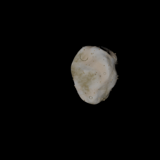

In [0]:
# TEST (check access to asteroid images)
i = 10
img_files = get_image_files(imagedir)
print(img_files[i])
im = PILImage.create(img_files[i])
ysize = im.shape[1]
print(im.size, ysize)
im.to_thumb(160)

## Preprocess Data

In [0]:
def label_func(fname):
    """
    retrieve centroid coords
    ysize = im.size[1], need to invert y axis
    """
    i = int(str(fname).split("/")[-1].split(".")[0])

    cx,cy = df[df.ID==i].cx.values[0], ysize-df[df.ID==i].cy.values[0]
    return tensor([cx,cy])

In [0]:
item_tfms  = [Resize(256)]
batch_tfms = [Normalize.from_stats(*imagenet_stats)] # add data augmentation here...

dblock = DataBlock(blocks    = (ImageBlock, PointBlock),
                   get_items = get_image_files,
                   get_y     = label_func,
                   splitter  = RandomSplitter(valid_pct=0.2, seed=42), # valid_pct: 20% of your dataset is used for validation
                   item_tfms = item_tfms,
                   batch_tfms= batch_tfms)

In [0]:
dls = dblock.dataloaders(imagedir, bs=8)

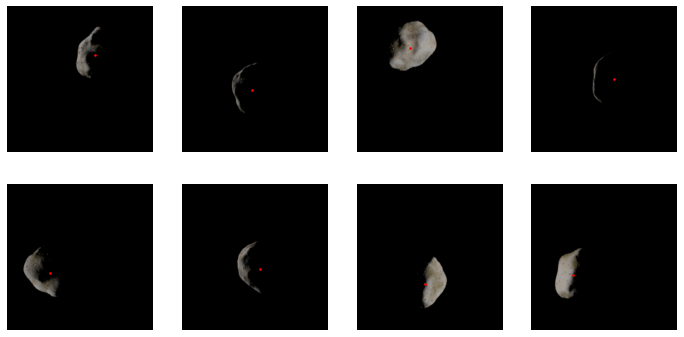

In [0]:
dls.show_batch()

## Training the Model

## Understanding the results